In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import pickle 
from typing import Dict, Any
from tqdm.notebook import tqdm

from ACI import *       # Gibbs & Candes (2021)
from agACI import *     # Zaffran et Al. (2022)
from dtACI import *     # Gibbs & Candes (2024)

In [213]:
forecasts = pd.read_pickle("new.pkl")
forecasts['horizon'] = (np.arange(len(forecasts)) % 6) + 1
forecasts["naive"] = forecasts.groupby(np.arange(len(forecasts)) // 6)["actual"].transform("first")
forecasts.head(10)

,actual,stgcn,lgbm_direct_median,arima,lgbm_direct_lower,lgbm_direct_upper,horizon,naive
2023-01-01 00:00:00+00:00,7851.432129,7889.245605,6626.377263,7660.308668,5668.209283,7222.207512,1,7851.432129
2023-01-01 01:00:00+00:00,8088.687012,7974.226074,6579.910121,7489.318373,5178.847177,7476.828777,2,7851.432129
2023-01-01 02:00:00+00:00,8076.753418,7967.929688,6553.983274,7434.695952,5550.499707,7496.508944,3,7851.432129
2023-01-01 03:00:00+00:00,8082.624023,8189.666992,7326.990246,7466.632945,5910.244411,7784.171767,4,7851.432129
2023-01-01 04:00:00+00:00,7895.537109,7962.151855,6981.456610,7491.369261,5708.713576,7901.231101,5,7851.432129
2023-01-01 05:00:00+00:00,7686.880371,7785.013184,6846.341096,7460.193466,5628.737044,7789.698951,6,7851.432129
2023-01-01 06:00:00+00:00,7462.700195,7502.748535,7800.288377,7660.308668,6813.400963,8891.027339,1,7462.700195
2023-01-01 07:00:00+00:00,7984.824219,7257.998047,7534.192926,7489.318373,6572.604630,8277.730867,2,7462.700195
2023-01-01 08:00:00+00:00,7868.450195,7091.039062,7483.262632,7434.695952,7117.988524,7868.705040,3,7462.700195
2023-01-01 09:00:00+00:00,7631.323242,7403.631348,7592.707782,7466.632945,6739.049905,7797.080719,4,7462.700195


In [214]:
# Define the models you want to evaluate
models = ['stgcn', "lgbm_direct_median", 'arima', "naive"]

# --- 2. Calculate Total RMSE and MAE ---
total_results = []
for model in models:
    # Calculate the error for the current model
    error = forecasts[model] - forecasts['actual']
    
    # Calculate MAE and RMSE
    mae = error.abs().mean()
    rmse = np.sqrt((error**2).mean())
    
    total_results.append({
        "Model": model,
        "Total MAE": mae,
        "Total RMSE": rmse
    })

total_results_df = pd.DataFrame(total_results).set_index("Model")

# --- 3. Calculate RMSE and MAE by Horizon ---
horizon_results = []
for horizon, group in forecasts.groupby('horizon'):
    horizon_data = {'Horizon': horizon}
    for model in models:
        # Calculate error for the current model and horizon
        error = group[model] - group['actual']
        
        # Calculate MAE and RMSE
        mae = error.abs().mean()
        rmse = np.sqrt((error**2).mean())
        
        horizon_data[f'{model}_mae'] = mae
        horizon_data[f'{model}_rmse'] = rmse
    horizon_results.append(horizon_data)

horizon_results_df = pd.DataFrame(horizon_results).set_index("Horizon")


# --- 4. Display Results ---
print("✅ Total Point Prediction Errors (Overall)")
print(total_results_df)

print("\n" + "="*50 + "\n")

print("✅ Point Prediction Errors by Horizon")
horizon_results_df

✅ Total Point Prediction Errors (Overall)
                      Total MAE   Total RMSE
Model                                       
stgcn               1220.294922  1704.355347
lgbm_direct_median  1682.850268  2368.271967
arima               2408.405544  3337.951551
naive                810.376465  1394.892700


✅ Point Prediction Errors by Horizon


,stgcn_mae,stgcn_rmse,lgbm_direct_median_mae,lgbm_direct_median_rmse,arima_mae,arima_rmse,naive_mae,naive_rmse
Horizon,,,,,,,,
1,854.297424,1201.969604,1522.548210,2195.446677,2392.065505,3350.961316,0.000000,0.000000
2,1035.808960,1433.287598,1597.225626,2282.817071,2392.591941,3344.814734,557.725830,874.257202
3,1203.761719,1679.205811,1670.963588,2358.872212,2407.871815,3347.049393,843.349121,1305.268433
4,1293.820923,1776.835449,1728.616340,2395.172449,2399.015264,3313.715894,990.234070,1509.570190
5,1409.417725,1925.504395,1765.030502,2449.627417,2429.330557,3340.743000,1158.757568,1759.537109
6,1524.662964,2060.455322,1812.717344,2513.807694,2429.558185,3330.282202,1312.192261,1957.429321


1140.430542  1639.412354
	854.297	1201.970	1035.809	1433.288	1203.762	1679.206	1293.821	1776.835	1409.418	1925.504	1524.663	2060.455

1	753.468323	1062.562744	1522.548210	2195.446677	2392.065505	3350.961316	0.000000	0.000000
2	958.486145	1350.631836	1597.225626	2282.817071	2392.591941	3344.814734	557.725830	874.257202
3	1129.044678	1604.120972	1670.963588	2358.872212	2407.871815	3347.049393	843.349121	1305.268433
4	1225.801758	1723.397827	1728.616340	2395.172449	2399.015264	3313.715894	990.234070	1509.570190
5	1328.959839	1893.077881	1765.030502	2449.627417	2429.330557	3340.743000	1158.757568	1759.537109
6	1446.822266	2011.403076	1812.717344	2513.807694	2429.558185	3330.282202	1312.192261	1957.429321


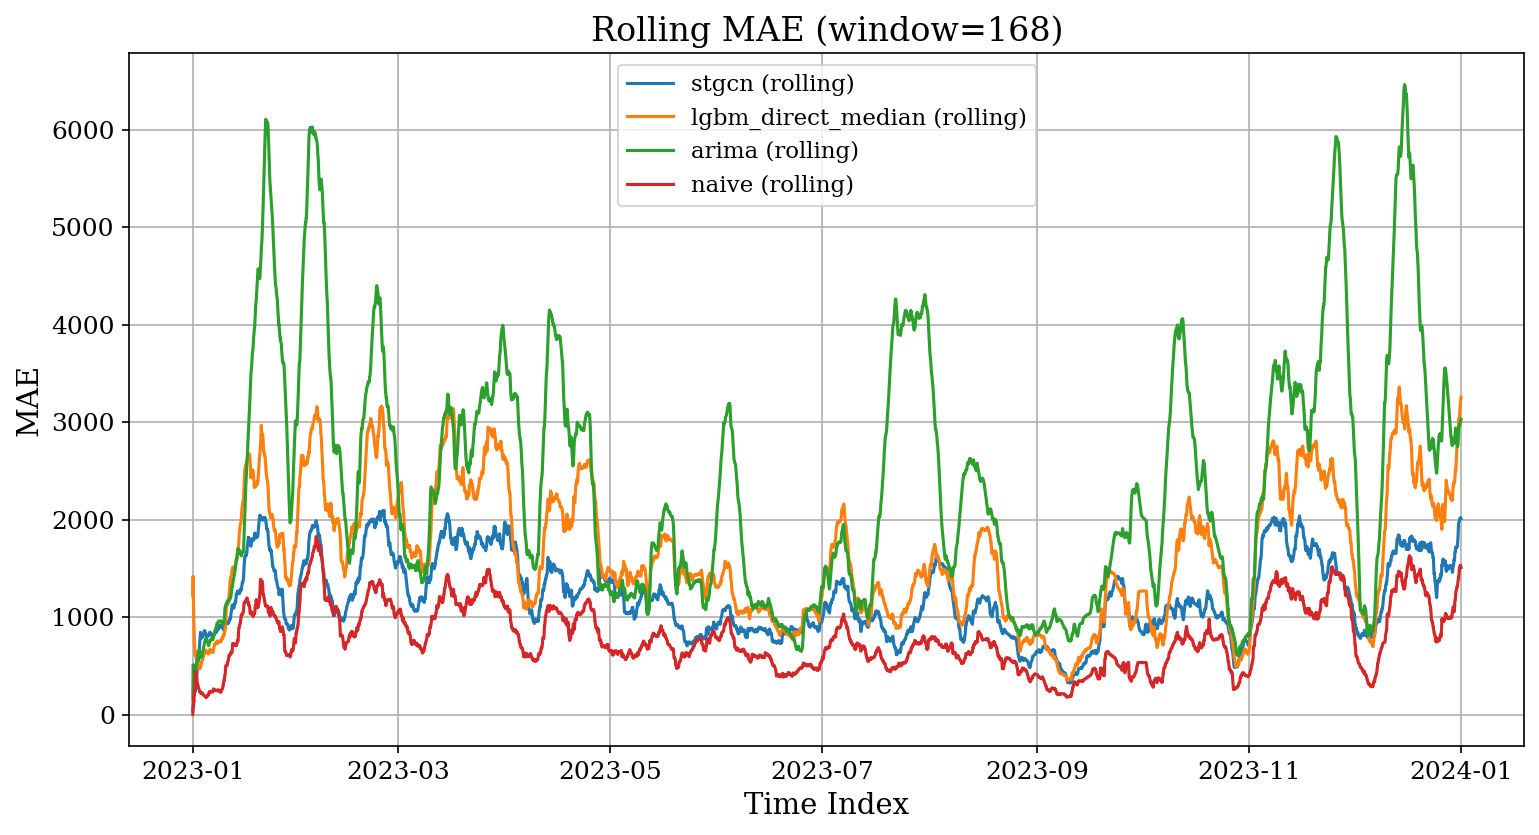

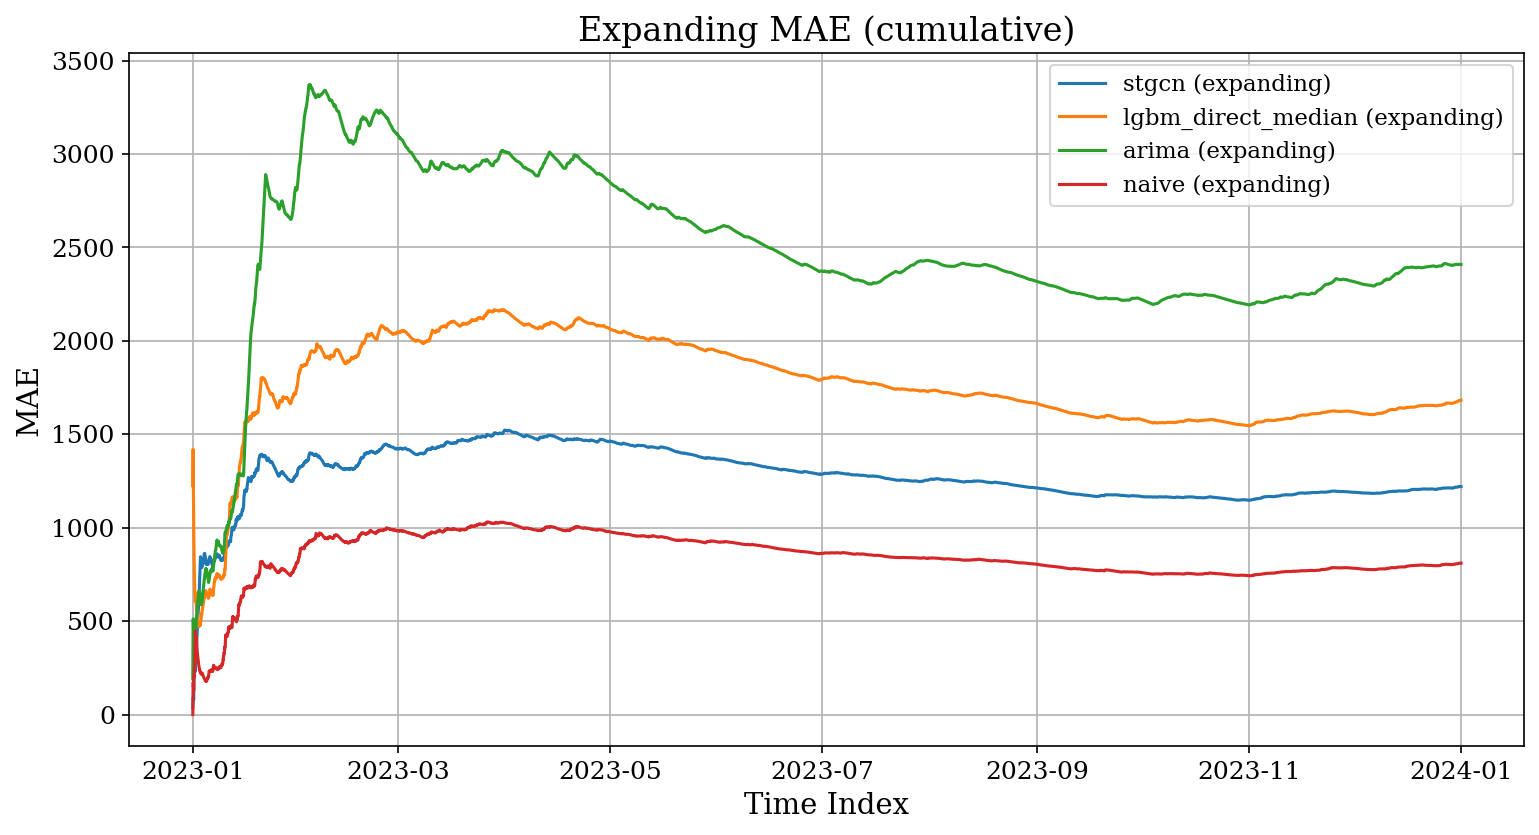

In [215]:
import matplotlib.pyplot as plt

window = 168  # rolling window size (adjust as needed)

rolling_mae = pd.DataFrame(index=forecasts.index)
expanding_mae = pd.DataFrame(index=forecasts.index)

for model in models:
    abs_error = (forecasts[model] - forecasts['actual']).abs()
    
    # rolling MAE (local behavior)
    rolling_mae[model] = abs_error.rolling(window, min_periods=1).mean()
    
    # expanding MAE (global stabilization)
    expanding_mae[model] = abs_error.expanding().mean()

# --- Plot rolling MAE ---
plt.figure(figsize=(12, 6))
for model in models:
    plt.plot(rolling_mae.index, rolling_mae[model], label=f"{model} (rolling)")
plt.title(f"Rolling MAE (window={window})")
plt.xlabel("Time Index")
plt.ylabel("MAE")
plt.legend()
plt.grid(True)
plt.show()

# --- Plot expanding MAE ---
plt.figure(figsize=(12, 6))
for model in models:
    plt.plot(expanding_mae.index, expanding_mae[model], label=f"{model} (expanding)")
plt.title("Expanding MAE (cumulative)")
plt.xlabel("Time Index")
plt.ylabel("MAE")
plt.legend()
plt.grid(True)
plt.show()

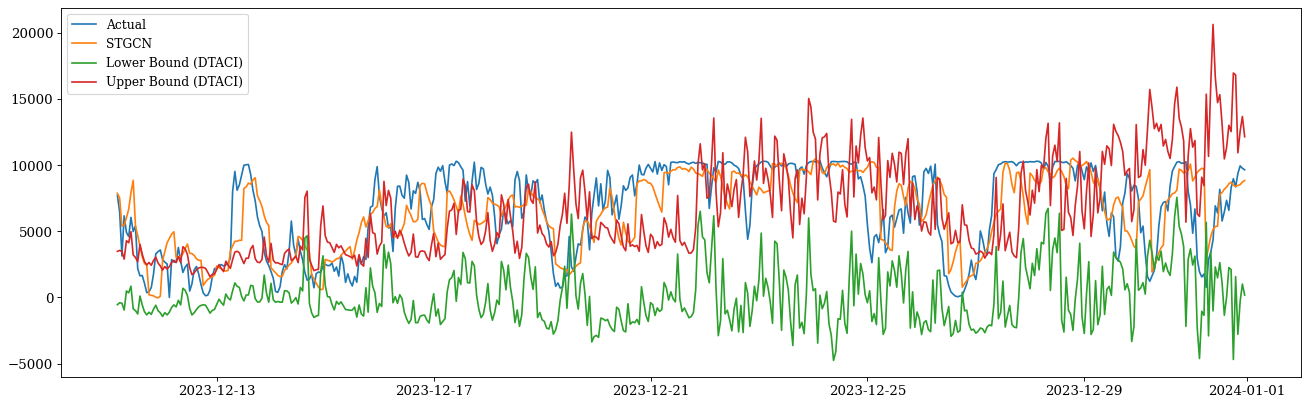

In [216]:
second_half = forecasts.iloc[len(forecasts) // 2 :]


plt.figure(figsize=(20, 6), dpi=80)

# take last 500 timesteps of actual + prediction
plt.plot(second_half.index[-500:], second_half['actual'].tail(500), label="Actual")
plt.plot(second_half.index[-500:], second_half['stgcn'].tail(500), label="STGCN")

# align lower bounds with the same index
lb = continuous_results["stgcn"]["dtaci"]["lower_bounds"][-500:]
ub = continuous_results["stgcn"]["dtaci"]["upper_bounds"][-500:]

plt.plot(second_half.index[-500:], lb, label="Lower Bound (DTACI)")
plt.plot(second_half.index[-500:], ub, label="Upper Bound (DTACI)")

plt.legend()
plt.show()

In [166]:
results_df[(results_df["Model"] == "STGCN") & (results_df["Method"] == "DTACI")]

,Model,Horizon,Method,Coverage,Width
3,STGCN,1,DTACI,0.890411,2983.338379
8,STGCN,2,DTACI,0.898630,3888.672363
13,STGCN,3,DTACI,0.895890,4868.314453
18,STGCN,4,DTACI,0.902740,5157.744629
23,STGCN,5,DTACI,0.902740,5395.041504
28,STGCN,6,DTACI,0.891781,5752.160156


In [141]:
def run_ocp(y: np.ndarray, preds: np.ndarray, alpha: float = 0.1,
            gamma: float = 0.001,
            gammas: np.ndarray = None, I: int = 50, window_size: int = 100,
            track_adaptations: bool = False, warmup_frac: float = 0.3,
            **kwargs) -> Dict[str, Dict[str, Dict[str, Any]]]:
    """
    Runs online conformal prediction for all methods, including OSSCP.
    For ACI, runs separately with gammas[0] and gammas[-1].
    """
    T = len(y)
    warmup = int(T * warmup_frac)
    methods = ["osscp", "aci", "dtaci", "agaci"]
    results = {}

    if gammas is None:
        gammas = np.full(T, gamma)

    for method in tqdm(methods, desc="Overall Progress"):
        # special-case ACI → test both endpoints
        gamma_list = [None]
        if method == "aci":
            gamma_list = [gammas[0], gammas[-1]]

        for gamma_val in gamma_list:
            residuals = list(np.abs(y[:warmup] - preds[:warmup]))
            alpha_t = alpha
            betas, covers, lengths = [], [], []
            lower_bounds, upper_bounds = [], []
            alpha_hist, cover_hist, res_hist = [], [], []

            for t in tqdm(range(warmup, T), desc=f"Processing {method.upper()}", leave=False):
                if method == "osscp":
                    recent_residuals = residuals[-window_size:]
                    q = np.quantile(recent_residuals, 1 - alpha)
                else:
                    alpha_t = np.clip(alpha_t, 1e-6, 1.0 - 1e-6)
                    q = np.quantile(residuals, 1 - alpha_t)

                lower, upper = preds[t] - q, preds[t] + q
                covered = (y[t] >= lower) and (y[t] <= upper)

                covers.append(covered)
                lengths.append(max(0, upper - lower))
                lower_bounds.append(lower)
                upper_bounds.append(upper)

                res_t = abs(y[t] - preds[t])
                residuals.append(res_t)

                if method != "osscp":
                    if method == "aci":
                        beta = int(covered)
                        out = aci(np.array(betas + [beta]), alpha, gamma_val, **kwargs)
                    else:
                        beta = np.mean(np.array(residuals) > res_t)
                        if method == "agaci":
                            out = agaci(np.array(betas + [beta]), alpha, gammas, **kwargs)
                        elif method == "dtaci":
                            I_curr = min(I, len(betas) + 1)
                            out = dtaci(np.array(betas + [beta]), alpha, gammas, I=I_curr, **kwargs)
                    betas.append(beta)
                    alpha_t = out["alphaSeq"][-1]

                if track_adaptations:
                    current_alpha = alpha if method == "osscp" else alpha_t
                    alpha_hist.append(current_alpha)
                    cover_hist.append(covered)
                    res_hist.append(res_t)

            key_name = method if method != "aci" else f"aci_gamma{gamma_val:.3f}"
            results[key_name] = {
                "coverage": np.mean(covers),
                "median_len": np.median(lengths),
                "lower_bounds": np.array(lower_bounds),
                "upper_bounds": np.array(upper_bounds),
                "alpha_hist": np.array(alpha_hist) if track_adaptations else None,
                "cover_hist": np.array(cover_hist) if track_adaptations else None,
                "res_hist": np.array(res_hist) if track_adaptations else None,
            }

    return results


def run_multistep_ocp_from_df(
    forecasts_df: pd.DataFrame,
    horizon_col: str = "horizon",
    actual_col: str = "actual",
    pred_col: str = "gcn_gru",
    gammas: np.ndarray = None,
    **kwargs
) -> Dict[int, Dict[str, Dict[str, Any]]]:
    """
    A wrapper to run OCP on a DataFrame grouped by horizon.

    - Runs an independent OCP process for each forecast horizon.
    - For ACI, results include both gammas[0] and gammas[-1] variants.
    """
    all_results = {}

    for horizon_level, group_df in tqdm(forecasts_df.groupby(horizon_col), desc="Processing Horizons"):
        y_true_h = group_df[actual_col].values
        y_preds_h = group_df[pred_col].values

        horizon_results = run_ocp(
            y=y_true_h,
            preds=y_preds_h,
            gammas=gammas,
            **kwargs
        )

        all_results[horizon_level] = horizon_results

    return all_results

In [142]:
results = {}

for model in ['stgcn', "lgbm_direct_median", 'arima']:
    results[model] = run_multistep_ocp_from_df(
        forecasts_df=forecasts,
        horizon_col="horizon",
        actual_col="actual",
        pred_col=model,
        alpha=0.1,
        gamma=0.001,
        gammas=np.linspace(0.001, 0.05, 50),
        I=500,
        window_size=500,
        track_adaptations=True,
        warmup_frac=0.5
    )

Processing Horizons:   0%|          | 0/6 [00:00<?, ?it/s]

Overall Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Processing OSSCP:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing DTACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing AGACI:   0%|          | 0/730 [00:00<?, ?it/s]

Overall Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Processing OSSCP:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing DTACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing AGACI:   0%|          | 0/730 [00:00<?, ?it/s]

Overall Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Processing OSSCP:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing DTACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing AGACI:   0%|          | 0/730 [00:00<?, ?it/s]

Overall Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Processing OSSCP:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing DTACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing AGACI:   0%|          | 0/730 [00:00<?, ?it/s]

Overall Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Processing OSSCP:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing DTACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing AGACI:   0%|          | 0/730 [00:00<?, ?it/s]

Overall Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Processing OSSCP:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing DTACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing AGACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing Horizons:   0%|          | 0/6 [00:00<?, ?it/s]

Overall Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Processing OSSCP:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing DTACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing AGACI:   0%|          | 0/730 [00:00<?, ?it/s]

Overall Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Processing OSSCP:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing DTACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing AGACI:   0%|          | 0/730 [00:00<?, ?it/s]

Overall Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Processing OSSCP:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing DTACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing AGACI:   0%|          | 0/730 [00:00<?, ?it/s]

Overall Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Processing OSSCP:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing DTACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing AGACI:   0%|          | 0/730 [00:00<?, ?it/s]

Overall Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Processing OSSCP:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing DTACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing AGACI:   0%|          | 0/730 [00:00<?, ?it/s]

Overall Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Processing OSSCP:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing DTACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing AGACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing Horizons:   0%|          | 0/6 [00:00<?, ?it/s]

Overall Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Processing OSSCP:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing DTACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing AGACI:   0%|          | 0/730 [00:00<?, ?it/s]

Overall Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Processing OSSCP:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing DTACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing AGACI:   0%|          | 0/730 [00:00<?, ?it/s]

Overall Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Processing OSSCP:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing DTACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing AGACI:   0%|          | 0/730 [00:00<?, ?it/s]

Overall Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Processing OSSCP:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing DTACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing AGACI:   0%|          | 0/730 [00:00<?, ?it/s]

Overall Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Processing OSSCP:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing DTACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing AGACI:   0%|          | 0/730 [00:00<?, ?it/s]

Overall Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Processing OSSCP:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing DTACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing AGACI:   0%|          | 0/730 [00:00<?, ?it/s]

In [221]:
import numpy as np
import pandas as pd
from typing import Dict, Any
from tqdm.auto import tqdm

# Assume aci, agaci, dtaci functions are defined elsewhere

def run_ocp(y: np.ndarray, preds: np.ndarray, alpha: float = 0.1,
            gamma: float = 0.001,
            gammas: np.ndarray = None, I: int = 50, window_size: int = 100,
            track_adaptations: bool = False, warmup_frac: float = 0.3,
            timestamps: np.ndarray = None,  # <-- ADDED: New parameter for timestamps
            **kwargs) -> Dict[str, Dict[str, Any]]:
    """
    Runs online conformal prediction for all methods, including OSSCP.
    For ACI, runs separately with gammas[0] and gammas[-1].
    """
    T = len(y)
    warmup = int(T * warmup_frac)
    methods = ["osscp", "aci", "dtaci", "agaci"]
    results = {}

    if gammas is None:
        gammas = np.full(T, gamma)

    for method in tqdm(methods, desc="Overall Progress"):
        # special-case ACI → test both endpoints
        gamma_list = [None]
        if method == "aci":
            gamma_list = [gammas[0], gammas[-1]]

        for gamma_val in gamma_list:
            residuals = list(np.abs(y[:warmup] - preds[:warmup]))
            alpha_t = alpha
            betas, covers, lengths = [], [], []
            lower_bounds, upper_bounds = [], []
            alpha_hist, cover_hist, res_hist = [], [], []

            for t in tqdm(range(warmup, T), desc=f"Processing {method.upper()}", leave=False):
                if method == "osscp":
                    recent_residuals = residuals[-window_size:]
                    q = np.quantile(recent_residuals, 1 - alpha)
                else:
                    alpha_t = np.clip(alpha_t, 1e-6, 1.0 - 1e-6)
                    q = np.quantile(residuals, 1 - alpha_t)

                lower, upper = preds[t] - q, preds[t] + q
                covered = (y[t] >= lower) and (y[t] <= upper)

                covers.append(covered)
                lengths.append(max(0, upper - lower))
                lower_bounds.append(lower)
                upper_bounds.append(upper)

                res_t = abs(y[t] - preds[t])
                residuals.append(res_t)

                if method != "osscp":
                    if method == "aci":
                        beta = int(covered)
                        out = aci(np.array(betas + [beta]), alpha, gamma_val, **kwargs)
                    else:
                        beta = np.mean(np.array(residuals) > res_t)
                        if method == "agaci":
                            out = agaci(np.array(betas + [beta]), alpha, gammas, **kwargs)
                            pass
                        elif method == "dtaci":
                            I_curr = min(I, len(betas) + 1)
                            out = dtaci(np.array(betas + [beta]), alpha, gammas, I=I_curr, **kwargs)
                            pass
                    betas.append(beta)
                    alpha_t = out["alphaSeq"][-1]


                if track_adaptations:
                    current_alpha = alpha if method == "osscp" else alpha_t
                    alpha_hist.append(current_alpha)
                    cover_hist.append(covered)
                    res_hist.append(res_t)

            key_name = method if method != "aci" else f"aci_gamma{gamma_val:.3f}"
            results[key_name] = {
                "coverage": np.mean(covers),
                "median_len": np.median(lengths),
                # <-- ADDED: Store the relevant timestamps
                "timestamps": timestamps[warmup:] if timestamps is not None else None,
                "lower_bounds": np.array(lower_bounds),
                "upper_bounds": np.array(upper_bounds),
                "alpha_hist": np.array(alpha_hist) if track_adaptations else None,
                "cover_hist": np.array(cover_hist) if track_adaptations else None,
                "res_hist": np.array(res_hist) if track_adaptations else None,
            }

    return results


def run_multistep_ocp_from_df(
    forecasts_df: pd.DataFrame,
    horizon_col: str = "horizon",
    actual_col: str = "actual",
    pred_col: str = "gcn_gru",
    gammas: np.ndarray = None,
    **kwargs
) -> Dict[int, Dict[str, Dict[str, Any]]]:
    """
    A wrapper to run OCP on a DataFrame grouped by horizon.

    - Runs an independent OCP process for each forecast horizon.
    - For ACI, results include both gammas[0] and gammas[-1] variants.
    """
    all_results = {}

    for horizon_level, group_df in tqdm(forecasts_df.groupby(horizon_col), desc="Processing Horizons"):
        y_true_h = group_df[actual_col].values
        y_preds_h = group_df[pred_col].values
        timestamps_h = group_df.index.values

        horizon_results = run_ocp(
            y=y_true_h,
            preds=y_preds_h,
            timestamps=timestamps_h, 
            gammas=gammas,
            **kwargs
        )

        all_results[horizon_level] = horizon_results

    return all_results


results = {}

for model in ['stgcn', "lgbm_direct_median", 'arima']:
    results[model] = run_multistep_ocp_from_df(
        forecasts_df=forecasts,
        horizon_col="horizon",
        actual_col="actual",
        pred_col=model,
        alpha=0.1,
        gamma=0.001,
        gammas=np.linspace(0.001, 0.05, 50),
        I=500,
        window_size=500,
        track_adaptations=True,
        warmup_frac=0.5
    )

Processing Horizons:   0%|          | 0/6 [00:00<?, ?it/s]

Overall Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Processing OSSCP:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing DTACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing AGACI:   0%|          | 0/730 [00:00<?, ?it/s]

Overall Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Processing OSSCP:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing DTACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing AGACI:   0%|          | 0/730 [00:00<?, ?it/s]

Overall Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Processing OSSCP:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing DTACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing AGACI:   0%|          | 0/730 [00:00<?, ?it/s]

Overall Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Processing OSSCP:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing DTACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing AGACI:   0%|          | 0/730 [00:00<?, ?it/s]

Overall Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Processing OSSCP:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing DTACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing AGACI:   0%|          | 0/730 [00:00<?, ?it/s]

Overall Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Processing OSSCP:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing DTACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing AGACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing Horizons:   0%|          | 0/6 [00:00<?, ?it/s]

Overall Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Processing OSSCP:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing DTACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing AGACI:   0%|          | 0/730 [00:00<?, ?it/s]

Overall Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Processing OSSCP:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing DTACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing AGACI:   0%|          | 0/730 [00:00<?, ?it/s]

Overall Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Processing OSSCP:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing DTACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing AGACI:   0%|          | 0/730 [00:00<?, ?it/s]

Overall Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Processing OSSCP:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing DTACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing AGACI:   0%|          | 0/730 [00:00<?, ?it/s]

Overall Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Processing OSSCP:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing DTACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing AGACI:   0%|          | 0/730 [00:00<?, ?it/s]

Overall Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Processing OSSCP:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing DTACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing AGACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing Horizons:   0%|          | 0/6 [00:00<?, ?it/s]

Overall Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Processing OSSCP:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing DTACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing AGACI:   0%|          | 0/730 [00:00<?, ?it/s]

Overall Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Processing OSSCP:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing DTACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing AGACI:   0%|          | 0/730 [00:00<?, ?it/s]

Overall Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Processing OSSCP:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing DTACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing AGACI:   0%|          | 0/730 [00:00<?, ?it/s]

Overall Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Processing OSSCP:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing DTACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing AGACI:   0%|          | 0/730 [00:00<?, ?it/s]

Overall Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Processing OSSCP:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing DTACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing AGACI:   0%|          | 0/730 [00:00<?, ?it/s]

Overall Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Processing OSSCP:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing ACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing DTACI:   0%|          | 0/730 [00:00<?, ?it/s]

Processing AGACI:   0%|          | 0/730 [00:00<?, ?it/s]

In [217]:
def run_ocp(y: np.ndarray, preds: np.ndarray, alpha: float = 0.1,
            gamma: float = 0.001,
            gammas: np.ndarray = None, I: int = 50, window_size: int = 100,
            track_adaptations: bool = False, warmup_frac: float = 0.3,
            start_idx: int = 0,  # New parameter to track original indices
            **kwargs) -> Dict[str, Dict[str, Any]]:
    """
    Runs online conformal prediction for all methods, including OSSCP.
    For ACI, runs separately with gammas[0] and gammas[-1].
    """
    T = len(y)
    warmup = int(T * warmup_frac)
    methods = ["osscp", "aci", "dtaci", "agaci"]
    results = {}

    if gammas is None:
        gammas = np.full(T, gamma)

    for method in tqdm(methods, desc="Overall Progress"):
        # special-case ACI → test both endpoints
        gamma_list = [None]
        if method == "aci":
            gamma_list = [gammas[0], gammas[-1]]

        for gamma_val in gamma_list:
            residuals = list(np.abs(y[:warmup] - preds[:warmup]))
            alpha_t = alpha
            betas, covers, lengths = [], [], []
            lower_bounds, upper_bounds = [], []
            alpha_hist, cover_hist, res_hist = [], [], []
            # Store original indices for alignment
            indices = []

            for t in tqdm(range(warmup, T), desc=f"Processing {method.upper()}", leave=False):
                # Store the original index (accounting for warmup offset)
                original_idx = start_idx + t
                indices.append(original_idx)
                
                if method == "osscp":
                    recent_residuals = residuals[-window_size:]
                    q = np.quantile(recent_residuals, 1 - alpha)
                else:
                    alpha_t = np.clip(alpha_t, 1e-6, 1.0 - 1e-6)
                    q = np.quantile(residuals, 1 - alpha_t)

                lower, upper = preds[t] - q, preds[t] + q
                covered = (y[t] >= lower) and (y[t] <= upper)

                covers.append(covered)
                lengths.append(max(0, upper - lower))
                lower_bounds.append(lower)
                upper_bounds.append(upper)

                res_t = abs(y[t] - preds[t])
                residuals.append(res_t)

                if method != "osscp":
                    if method == "aci":
                        beta = int(covered)
                        out = aci(np.array(betas + [beta]), alpha, gamma_val, **kwargs)
                    else:
                        beta = np.mean(np.array(residuals) > res_t)
                        if method == "agaci":
                            out = agaci(np.array(betas + [beta]), alpha, gammas, **kwargs)
                        elif method == "dtaci":
                            I_curr = min(I, len(betas) + 1)
                            out = dtaci(np.array(betas + [beta]), alpha, gammas, I=I_curr, **kwargs)
                    betas.append(beta)
                    alpha_t = out["alphaSeq"][-1]

                if track_adaptations:
                    current_alpha = alpha if method == "osscp" else alpha_t
                    alpha_hist.append(current_alpha)
                    cover_hist.append(covered)
                    res_hist.append(res_t)

            key_name = method if method != "aci" else f"aci_gamma{gamma_val:.3f}"
            results[key_name] = {
                "coverage": np.mean(covers),
                "median_len": np.median(lengths),
                "lower_bounds": np.array(lower_bounds),
                "upper_bounds": np.array(upper_bounds),
                "indices": np.array(indices),  # Original indices for alignment
                "alpha_hist": np.array(alpha_hist) if track_adaptations else None,
                "cover_hist": np.array(cover_hist) if track_adaptations else None,
                "res_hist": np.array(res_hist) if track_adaptations else None,
            }

    return results


def run_multistep_ocp_from_df(
    forecasts_df: pd.DataFrame,
    horizon_col: str = "horizon",
    actual_col: str = "actual",
    pred_cols: list = None,  # Changed to support multiple prediction columns
    gammas: np.ndarray = None,
    **kwargs
) -> Dict[str, Dict[int, Dict[str, Dict[str, Any]]]]:
    """
    A wrapper to run OCP on a DataFrame grouped by horizon for multiple models.
    
    Returns structure: {model_name: {horizon: {cp_method: results}}}
    
    - Runs an independent OCP process for each forecast horizon and each model.
    - For ACI, results include both gammas[0] and gammas[-1] variants.
    """
    if pred_cols is None:
        # Auto-detect prediction columns (exclude actual, horizon, and index columns)
        exclude_cols = {actual_col, horizon_col, 'index'} | set(forecasts_df.select_dtypes(include=['datetime']).columns)
        pred_cols = [col for col in forecasts_df.columns if col not in exclude_cols]
    
    all_results = {}
    
    # Organize by model first
    for model_name in pred_cols:
        all_results[model_name] = {}
        
        for horizon_level, group_df in tqdm(
            forecasts_df.groupby(horizon_col), 
            desc=f"Processing {model_name} Horizons",
            leave=False
        ):
            # Sort by index to ensure proper time ordering
            group_df = group_df.sort_index()
            
            y_true_h = group_df[actual_col].values
            y_preds_h = group_df[model_name].values
            
            # Get the starting index for this horizon group
            start_idx = group_df.index[0] if hasattr(group_df.index, '__getitem__') else 0

            horizon_results = run_ocp(
                y=y_true_h,
                preds=y_preds_h,
                gammas=gammas,
                start_idx=start_idx,  # Pass the starting index
                **kwargs
            )

            all_results[model_name][horizon_level] = horizon_results

    return all_results


def get_prediction_intervals_df(
    ocp_results: Dict[str, Dict[int, Dict[str, Dict[str, Any]]]],
    forecasts_df: pd.DataFrame,
    method: str = "osscp"
) -> pd.DataFrame:
    """
    Convert OCP results back to a DataFrame with prediction intervals aligned to original indices.
    
    Args:
        ocp_results: Results from run_multistep_ocp_from_df
        forecasts_df: Original forecasts DataFrame
        method: Which CP method to extract ('osscp', 'aci', 'dtaci', 'agaci')
    
    Returns:
        DataFrame with columns: model, horizon, original_index, lower_bound, upper_bound
    """
    interval_data = []
    
    for model_name, model_results in ocp_results.items():
        for horizon_level, horizon_results in model_results.items():
            if method in horizon_results:
                method_results = horizon_results[method]
                indices = method_results['indices']
                lower_bounds = method_results['lower_bounds']
                upper_bounds = method_results['upper_bounds']
                
                for i, (idx, lower, upper) in enumerate(zip(indices, lower_bounds, upper_bounds)):
                    interval_data.append({
                        'model': model_name,
                        'horizon': horizon_level,
                        'original_index': idx,
                        'lower_bound': lower,
                        'upper_bound': upper
                    })
    
    return pd.DataFrame(interval_data)

In [218]:
# Assuming your DataFrame has prediction columns like 'gcn_gru', 'arima', 'lgbm_direct_median', etc.
pred_columns = ['stgcn', 'arima', 'lgbm_direct_median']

# Run OCP for all models (all horizons stacked together)
ocp_results = run_multistep_ocp_from_df(
    forecasts_df=df,
    horizon_col="horizon", 
    actual_col="actual",
    pred_cols=pred_columns,
    alpha=0.1,
    gamma=0.001,
    warmup_frac=0.3
)

# Structure: ocp_results['stgcn']['osscp']['coverage']
#           ocp_results['arima']['aci_gamma0.001']['median_len']

# Get prediction intervals as DataFrame
intervals_df = get_prediction_intervals_df(ocp_results, df, method="osscp")

KeyError: 'horizon'

In [174]:
results["stgcn"][1]["dtaci"]["lower_bounds"]

array([ 2.91095264e+03,  2.90782471e+03,  4.35268188e+02,  3.20872070e+02,
        4.78930322e+03,  4.19554395e+03,  1.52826062e+03,  7.98590820e+02,
        8.25694092e+02, -1.34961572e+03, -1.03822668e+03,  2.09711719e+03,
        1.31418079e+03,  1.18895459e+03, -5.94360352e+01,  1.30025635e+01,
        1.42244507e+02,  2.59902539e+03,  2.11182471e+03,  9.55283325e+02,
       -3.42175293e+01,  5.36321411e+02,  6.09724731e+02,  2.88903809e+02,
        6.75314697e+02,  3.62009888e+02,  5.43919678e+01, -3.56060059e+02,
        4.19914307e+02,  1.77500598e+03,  4.50183105e+01,  6.31388184e+02,
        2.82283716e+03,  4.19504150e+03,  3.16501465e+02,  2.78169238e+03,
        3.55490649e+03,  1.68055957e+03,  4.77511353e+02,  2.23169922e+03,
        3.83139648e+03,  1.36304834e+03,  9.99901123e+02,  5.55595215e+02,
        2.56587524e+02,  2.08552612e+02,  9.58041992e+01,  1.11423425e+03,
        2.00780713e+03,  3.32022388e+03,  8.43158081e+02,  2.72663086e+03,
        3.54219971e+03,  

In [175]:
def reassemble_multistep_results(results: Dict, max_horizon: int = None) -> Dict[str, Dict[str, Dict[str, np.ndarray]]]:
    """
    Reassemble multi-step OCP results from separate horizon runs into continuous sequences.
    
    Args:
        results: Dict with structure results[model][horizon][method][metric]
        max_horizon: Maximum horizon to include (if None, uses all available)
    
    Returns:
        Dict with structure reassembled[model][method][metric] containing continuous arrays
    """
    reassembled = {}
    
    for model_name, model_results in results.items():
        reassembled[model_name] = {}
        
        # Get all horizons and sort them
        horizons = sorted(model_results.keys())
        if max_horizon:
            horizons = [h for h in horizons if h <= max_horizon]
        
        # Get all methods from first horizon
        methods = list(model_results[horizons[0]].keys())
        
        for method in methods:
            reassembled[model_name][method] = {}
            
            # Get all metrics from first method/horizon
            metrics = list(model_results[horizons[0]][method].keys())
            
            for metric in metrics:
                # Skip None values (like when track_adaptations=False)
                if model_results[horizons[0]][method][metric] is None:
                    reassembled[model_name][method][metric] = None
                    continue
                
                # Concatenate arrays from all horizons
                metric_data = []
                for horizon in horizons:
                    data = model_results[horizon][method][metric]
                    if isinstance(data, np.ndarray):
                        metric_data.extend(data)
                    else:
                        # Handle scalar metrics like coverage, median_len
                        metric_data.append(data)
                
                reassembled[model_name][method][metric] = np.array(metric_data)
    
    return reassembled

# Usage example:
continuous_results = reassemble_multistep_results(results)

# Now access continuous sequences:
stgcn_dtaci_bounds = continuous_results["stgcn"]["dtaci"]["lower_bounds"]

In [177]:
continuous_results

{'stgcn': {'osscp': {'coverage': array([0.86986301, 0.86712329, 0.87945205, 0.86986301, 0.8630137 ,
          0.87260274]),
   'median_len': array([2967.8945, 3798.3264, 4783.9004, 5002.2026, 5344.551 , 5645.6035],
         dtype=float32),
   'lower_bounds': array([3058.769 , 3052.9062,  574.2738, ..., 2693.387 , 3895.2786,
          2712.161 ], shape=(4380,), dtype=float32),
   'upper_bounds': array([ 6470.528,  6464.665,  3995.246, ...,  9599.076, 10800.968,
           9617.85 ], shape=(4380,), dtype=float32),
   'alpha_hist': array([0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1], shape=(4380,)),
   'cover_hist': array([ True, False,  True, ...,  True,  True, False], shape=(4380,)),
   'res_hist': array([  88.42578, 1974.0093 ,  448.24854, ...,  242.25   ,  948.8994 ,
          3490.8052 ], shape=(4380,), dtype=float32)},
  'aci_gamma0.001': {'coverage': array([0.89041096, 0.8890411 , 0.89589041, 0.88767123, 0.89178082,
          0.89041096]),
   'median_len': array([3324.4714, 4223.166 , 5169.2

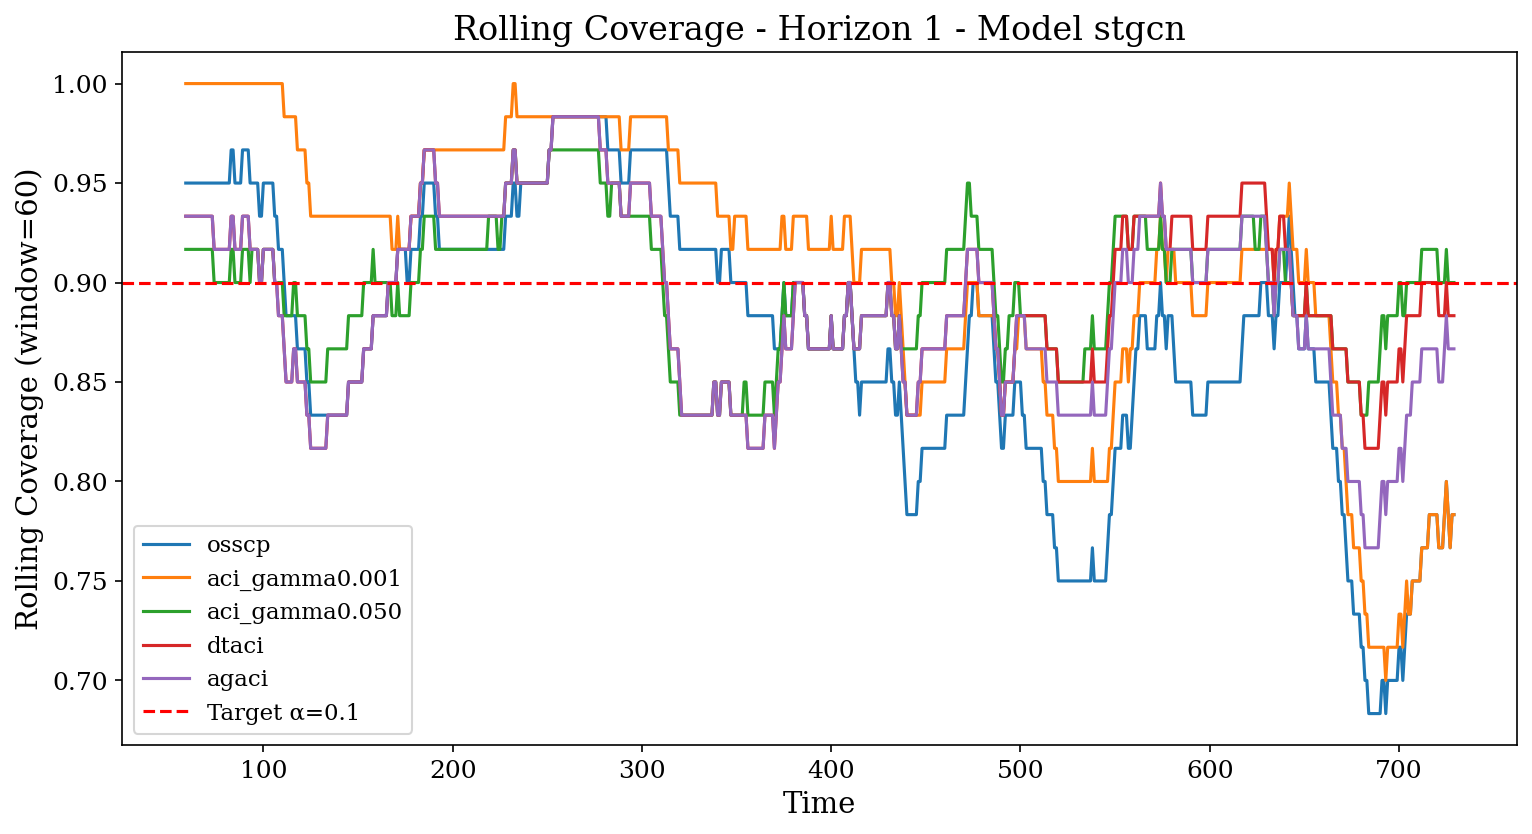

In [222]:
horizon = 1
window = 60

plt.figure(figsize=(12, 6))

for method, stats in results["stgcn"][horizon].items():
    if stats["cover_hist"] is not None:  # some methods may not track
        rc = pd.Series(stats["cover_hist"]).rolling(window).mean()
        plt.plot(rc, label=method)

plt.axhline(0.9, color="red", linestyle="--", label="Target α=0.1")
plt.xlabel("Time")
plt.ylabel(f"Rolling Coverage (window={window})")
plt.title(f"Rolling Coverage - Horizon {horizon} - Model stgcn")
plt.legend()
plt.show()

In [165]:
results_df

,Model,Horizon,Method,Coverage,Width
0,STGCN,1,OSSCP,0.869863,2967.894531
1,STGCN,1,ACI_GAMMA0.001,0.890411,3324.471436
2,STGCN,1,ACI_GAMMA0.050,0.897260,3008.221924
3,STGCN,1,DTACI,0.890411,2983.338379
4,STGCN,1,AGACI,0.893151,3015.976074
...,...,...,...,...,...
61,ARIMA,6,OSSCP,0.847945,9389.272578
62,ARIMA,6,ACI_GAMMA0.001,0.872603,10360.819601
63,ARIMA,6,ACI_GAMMA0.050,0.893151,9445.524761
64,ARIMA,6,DTACI,0.887671,9787.304009


✅ Final plot saved as 'tradeoff_plot_final_layout.pdf'


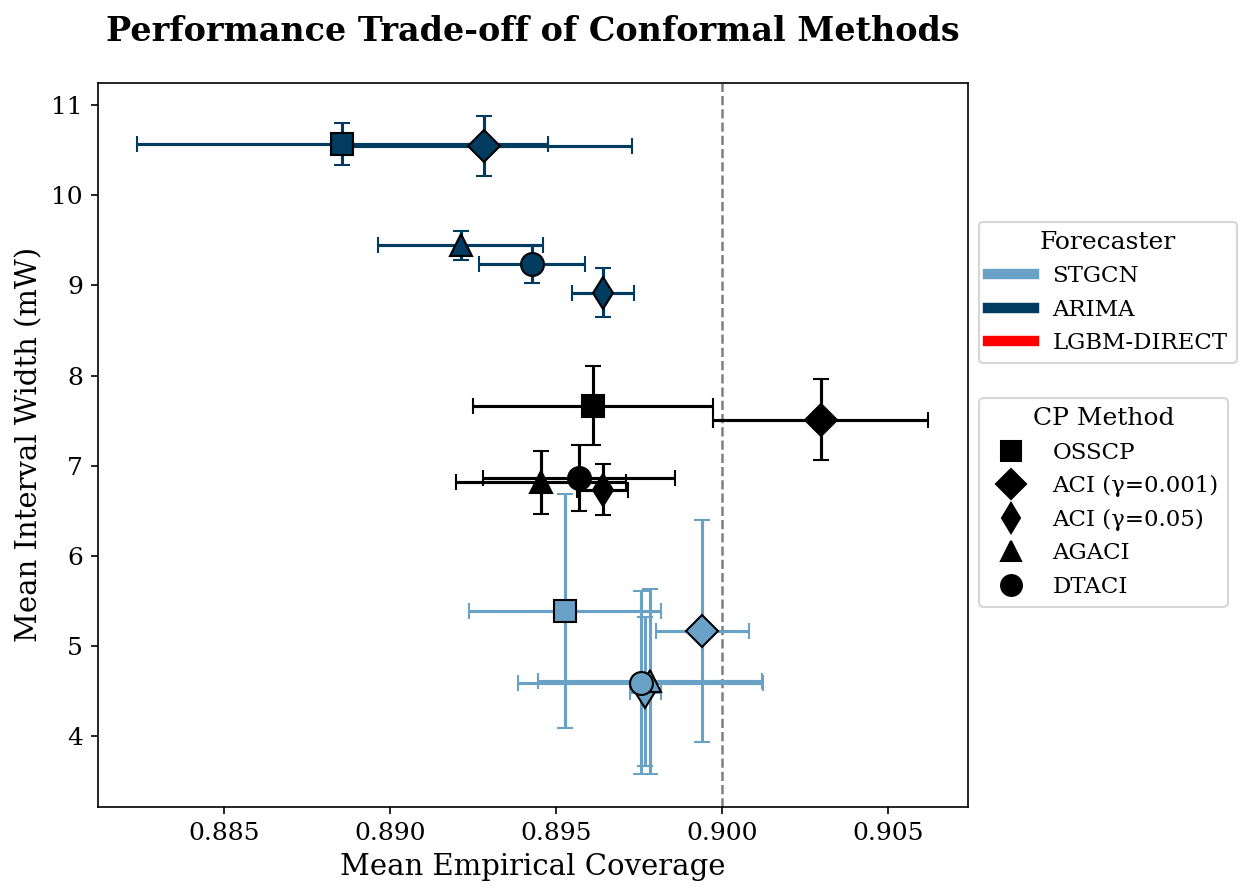

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# --- Step 1: Process your populated 'results' dictionary ---
def create_results_dataframe(results: dict) -> pd.DataFrame:
    """Processes the nested results dictionary into a tidy DataFrame."""
    processed_data = []
    for model_name, model_results in results.items():
        for horizon, horizon_results in model_results.items():
            for method, metrics in horizon_results.items():
                processed_data.append({
                    "Model": model_name.upper().replace("_", "-"),
                    "Horizon": horizon,
                    "Method": method.upper(),
                    "Coverage": metrics.get("coverage", np.nan),
                    "Width": metrics.get("median_len", np.nan)
                })
    return pd.DataFrame(processed_data)

# --- Step 2: Create the Plot with Top & Side Legends ---
def plot_final_tradeoff(results_df: pd.DataFrame, alpha: float = 0.1, output_filename="tradeoff_plot_final_layout.pdf"):
    """
    Generates a high-quality trade-off plot with one legend above and one to the right.
    """
    # --- Setup professional aesthetics ---
    plt.style.use('default')
    plt.rcParams.update({
        "font.family": "serif", "font.size": 12, "axes.titlesize": 16,
        "axes.labelsize": 14, "xtick.labelsize": 12, "ytick.labelsize": 12,
        "legend.fontsize": 11, "legend.title_fontsize": 12, "figure.dpi": 150,
    })
    
    fig, ax = plt.subplots(figsize=(8, 7))
    
    # --- Define aesthetics ---
    model_colors = {"STGCN": "#6aa1c7", "ARIMA": "#003b60", "LGBM-DIRECT": "red"}
    method_markers = {
        "OSSCP": "s",
        "ACI_GAMMA0.001": "D",
        "ACI_GAMMA0.050": "d",
        "AGACI": "^",
        "DTACI": "o"
    }
    pretty_names = {
        "OSSCP": "OSSCP",
        "ACI_GAMMA0.001": "ACI (γ=0.001)",
        "ACI_GAMMA0.050": "ACI (γ=0.05)",
        "AGACI": "AGACI",
        "DTACI": "DTACI"
    }

    # --- Plot data ---
    for (model, method), group in results_df.groupby(["Model", "Method"]):
        ax.errorbar(
            x=group['Coverage'].mean(),
            y=group['Width'].mean() / 1000,          # convert kW → MW
            xerr=group['Coverage'].std(),
            yerr=group['Width'].std() / 1000,        # convert kW → MW
            marker=method_markers.get(method, 'x'),
            color=model_colors.get(model, 'black'),
            linestyle='None', markersize=11, markeredgecolor='black',
            elinewidth=1.5, capsize=4, zorder=10
        )


    # --- Formatting and Reference Line ---
    ax.axvline(1 - alpha, color='black', linestyle='--', linewidth=1.2, zorder=5, alpha=0.5)

    ax.set_title("Performance Trade-off of Conformal Methods", fontweight='bold', pad=20)
    ax.set_xlabel("Mean Empirical Coverage")
    ax.set_ylabel("Mean Interval Width (mW)")
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white') 

    # --- Create proxy artists for the external legends ---
    model_handles = [
        Line2D([0], [0], color=c, lw=5, label=l)
        for l, c in model_colors.items()
    ]
    method_handles = [
        Line2D([0], [0], marker=m, color='black', linestyle='None', markersize=10, label=pretty_names.get(l, l))
        for l, m in method_markers.items()
    ]
    
    # --- Place legends above and to the right of the plot ---
    fig.legend(handles=model_handles, title="Forecaster",
               loc='center left', bbox_to_anchor=(0.85, 0.6), frameon=True)

    fig.legend(handles=method_handles, title="CP Method",
               loc='center left', bbox_to_anchor=(0.85, 0.40), frameon=True)

    # Adjust subplot to make room for both legends
    plt.subplots_adjust(top=0.8, right=0.85)
    
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"✅ Final plot saved as '{output_filename}'")
    plt.show()


# --- Full Workflow ---
if __name__ == "__main__":

    # 1. Create the DataFrame
    results_df = create_results_dataframe(results)
    
    # 2. Generate and save the final plot
    plot_final_tradeoff(results_df)

In [223]:
# --- Step 0: Compute coverage and width for native LightGBM bounds ---
def compute_interval_metrics(forecasts: pd.DataFrame, lower_col: str, upper_col: str, actual_col: str = "actual"):
    """Compute empirical coverage and median interval length for given prediction intervals."""
    within_bounds = (forecasts[actual_col] >= forecasts[lower_col]) & (forecasts[actual_col] <= forecasts[upper_col])
    coverage = within_bounds.mean()
    median_len = (forecasts[upper_col] - forecasts[lower_col]).median()
    return {"coverage": coverage, "median_len": median_len}


# Example: compute for lgbm_qr intervals
lgbm_native_results = {}

for h in forecasts["horizon"].unique():
    subset = forecasts[forecasts["horizon"] == h]
    metrics = compute_interval_metrics(subset, "lgbm_direct_lower", "lgbm_direct_upper")
    lgbm_native_results[h] = {"NATIVE": metrics}   # "NATIVE" method tag for clarity


# --- Step 1: Insert into your results dict ---
# Assuming `results` is structured as results[model][horizon][method]
if "lgbm_direct" not in results:
    results["lgbm_direct_median"] = {}

for h, metrics in lgbm_native_results.items():
    results["lgbm_direct_median"].setdefault(h, {})
    results["lgbm_direct_median"][h].update(metrics)


# --- Step 2: Rebuild the results_df ---
results_df = create_results_dataframe(results)

✅ Final plot saved as 'tradeoff_plot_final_layout.pdf'


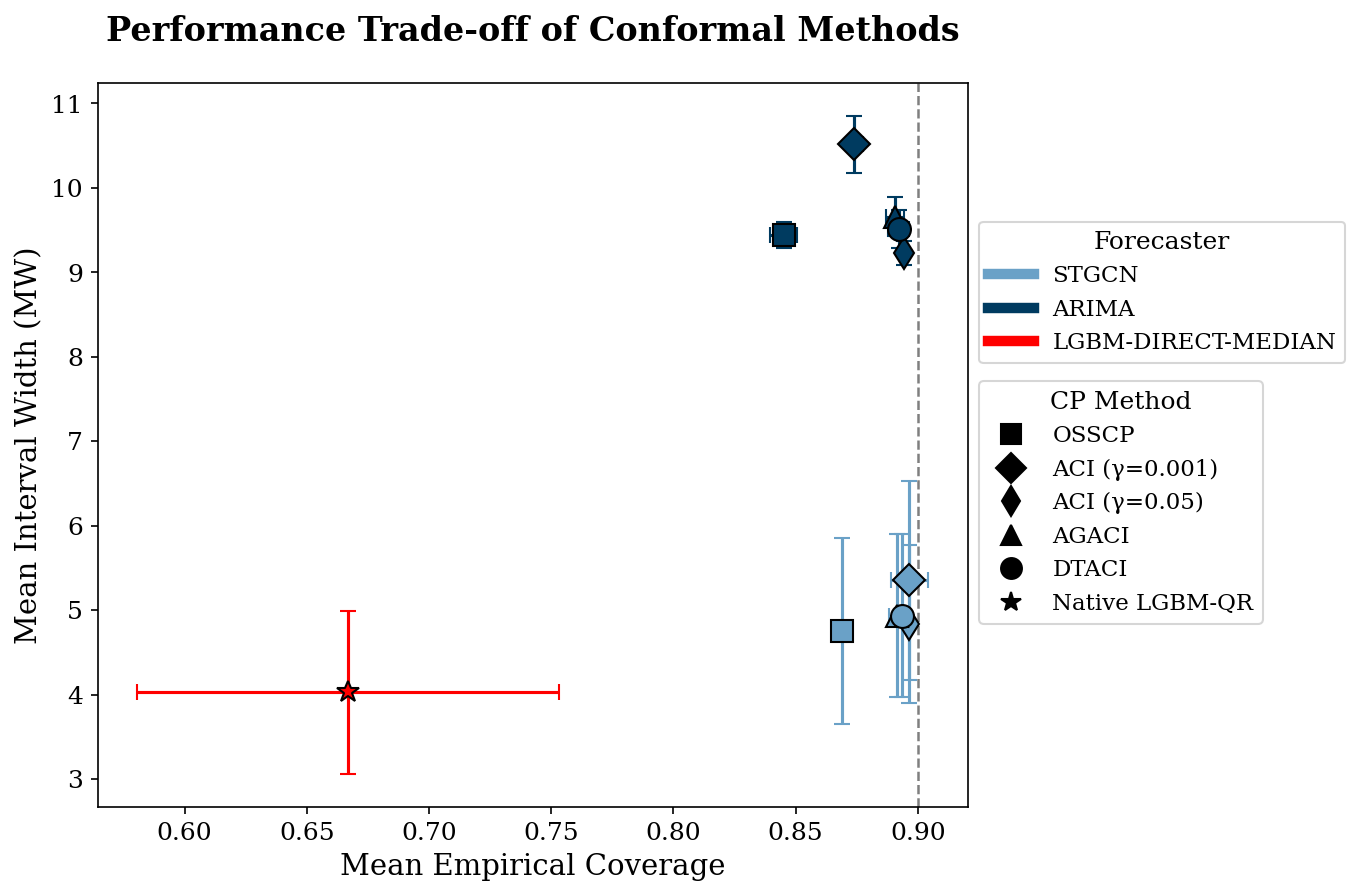

In [224]:
def plot_final_tradeoff(results_df: pd.DataFrame, alpha: float = 0.1, output_filename="tradeoff_plot_final_layout.pdf"):
    """
    Generates a high-quality trade-off plot with one legend above and one to the right.
    """
    # --- Setup professional aesthetics ---
    plt.style.use('default')
    plt.rcParams.update({
        "font.family": "serif", "font.size": 12, "axes.titlesize": 16,
        "axes.labelsize": 14, "xtick.labelsize": 12, "ytick.labelsize": 12,
        "legend.fontsize": 11, "legend.title_fontsize": 12, "figure.dpi": 150,
    })
    
    fig, ax = plt.subplots(figsize=(8, 7))
    
    # --- Define aesthetics ---
    model_colors = {"STGCN": "#6aa1c7", "ARIMA": "#003b60", "LGBM-DIRECT-MEDIAN": "red"}
    method_markers = {
        "OSSCP": "s",
        "ACI_GAMMA0.001": "D",
        "ACI_GAMMA0.050": "d",
        "AGACI": "^",
        "DTACI": "o",
        "NATIVE": "*"   # ⭐ added for native LGBM intervals
    }
    pretty_names = {
        "OSSCP": "OSSCP",
        "ACI_GAMMA0.001": "ACI (γ=0.001)",
        "ACI_GAMMA0.050": "ACI (γ=0.05)",
        "AGACI": "AGACI",
        "DTACI": "DTACI",
        "NATIVE": "Native LGBM-QR"   # readable name for legend
    }

    # --- Plot data ---
    for (model, method), group in results_df.groupby(["Model", "Method"]):
        ax.errorbar(
            x=group['Coverage'].mean(),
            y=group['Width'].mean() / 1000,          # convert kW → MW
            xerr=group['Coverage'].std(),
            yerr=group['Width'].std() / 1000,        # convert kW → MW
            marker=method_markers.get(method, 'x'),
            color=model_colors.get(model, 'black'),
            linestyle='None', markersize=11, markeredgecolor='black',
            elinewidth=1.5, capsize=4, zorder=10
        )

    # --- Formatting and Reference Line ---
    ax.axvline(1 - alpha, color='black', linestyle='--', linewidth=1.2, zorder=5, alpha=0.5)

    ax.set_title("Performance Trade-off of Conformal Methods", fontweight='bold', pad=20)
    ax.set_xlabel("Mean Empirical Coverage")
    ax.set_ylabel("Mean Interval Width (MW)")
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white') 

    # --- Create proxy artists for the external legends ---
    model_handles = [
        Line2D([0], [0], color=c, lw=5, label=l)
        for l, c in model_colors.items()
    ]
    method_handles = [
        Line2D([0], [0], marker=m, color='black', linestyle='None', markersize=10, label=pretty_names.get(l, l))
        for l, m in method_markers.items()
    ]
    
    # --- Place legends above and to the right of the plot ---
    fig.legend(handles=model_handles, title="Forecaster",
               loc='center left', bbox_to_anchor=(0.85, 0.6), frameon=True)

    fig.legend(handles=method_handles, title="CP Method",
               loc='center left', bbox_to_anchor=(0.85, 0.40), frameon=True)

    # Adjust subplot to make room for both legends
    plt.subplots_adjust(top=0.8, right=0.85)
    
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"✅ Final plot saved as '{output_filename}'")
    plt.show()


plot_final_tradeoff(results_df)

In [225]:
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import matplotlib.pyplot as plt
import pandas as pd

def plot_final_tradeoff(results_df: pd.DataFrame, alpha: float = 0.1, 
                        output_filename="tradeoff_plot_final_layout.pdf"):
    """
    Generates a high-quality trade-off plot with two legends and an inset zoom:
    inset sits top-left, zooms into bottom-right region of the main plot.
    """
    # --- Setup professional aesthetics ---
    plt.style.use('default')
    plt.rcParams.update({
        "font.family": "serif", "font.size": 12, "axes.titlesize": 16,
        "axes.labelsize": 14, "xtick.labelsize": 12, "ytick.labelsize": 12,
        "legend.fontsize": 11, "legend.title_fontsize": 12, "figure.dpi": 150,
    })
    
    fig, ax = plt.subplots(figsize=(8, 7))
    
    # --- Define aesthetics ---
    model_colors = {"STGCN": "#6aa1c7", "ARIMA": "#003b60", "LGBM-DIRECT-MEDIAN": "red"}
    pretty_model_names = {
        "STGCN": "ST-GCN",
        "ARIMA": "ARIMA",
        "LGBM-DIRECT-MEDIAN": "LGBM-QR"
    }

    method_markers = {
        "OSSCP": "s", "ACI_GAMMA0.001": "D", "ACI_GAMMA0.050": "d",
        "AGACI": "^", "DTACI": "o", "NATIVE": "*"
    }
    pretty_names = {
        "OSSCP": "OSSCP",
        "ACI_GAMMA0.001": "ACI (γ=0.001)",
        "ACI_GAMMA0.050": "ACI (γ=0.05)",
        "AGACI": "AGACI",
        "DTACI": "DTACI",
        "NATIVE": "LGBM-QR"
    }

    # --- Plot data (main axes) ---
    for (model, method), group in results_df.groupby(["Model", "Method"]):
        ax.errorbar(
            x=group['Coverage'].mean(),
            y=group['Width'].mean() / 1000,
            xerr=group['Coverage'].std(),
            yerr=group['Width'].std() / 1000,
            marker=method_markers.get(method, 'x'),
            color=model_colors.get(model, 'black'),
            linestyle='None', markersize=11, markeredgecolor='black',
            elinewidth=1.5, capsize=4, zorder=10
        )

    # --- Formatting ---
    ax.axvline(1 - alpha, color='black', linestyle='--', linewidth=1.2, zorder=5, alpha=0.5)
    ax.set_title("Performance Trade-off of Conformal Methods", fontweight='bold', pad=20)
    ax.set_xlabel("Mean Empirical Coverage")
    ax.set_ylabel("Mean Interval Width (MW)")
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white') 

    # --- Legends ---
    model_handles = [
        Line2D([0], [0], color=c, lw=5, 
               label=pretty_model_names.get(l, l)) 
        for l, c in model_colors.items()
    ]
    method_handles = [
        Line2D([0], [0], marker=m, color='black', linestyle='None',
               markersize=10, label=pretty_names.get(l, l))
        for l, m in method_markers.items()
    ]
    
    fig.legend(handles=model_handles, title="Forecaster",
               loc='center left', bbox_to_anchor=(0.85, 0.6), frameon=True)
    fig.legend(handles=method_handles, title="CP Method",
               loc='center left', bbox_to_anchor=(0.85, 0.40), frameon=True)
    plt.subplots_adjust(top=0.8, right=0.85)

    # --- Inset: sits top-left but zooms bottom-right ---
    axins = inset_axes(ax, width="40%", height="40%", loc="upper left", borderpad=2)

    for (model, method), group in results_df.groupby(["Model", "Method"]):
        axins.errorbar(
            x=group['Coverage'].mean(),
            y=group['Width'].mean() / 1000,
            xerr=group['Coverage'].std(),
            yerr=group['Width'].std() / 1000,
            marker=method_markers.get(method, 'x'),
            color=model_colors.get(model, 'black'),
            linestyle='None', markersize=9, markeredgecolor='black',
            elinewidth=1.2, capsize=3, zorder=10
        )

    # --- Zoom into bottom-right of main ---
    axins.set_xlim(0.86, 0.905)   # adjust as needed
    axins.set_ylim(3.26, 6.6)     # adjust as needed
    axins.tick_params(labelleft=True, labelbottom=True)
    
    # reference lines
    axins.axhline(0.9, color="black", linestyle="--", linewidth=1.0, alpha=0.5)
    axins.axvline(0.9, color="black", linestyle="--", linewidth=1.0, alpha=0.5)

    # --- Draw rectangle + connecting lines ---
    mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.7")  # loc1/loc2 = corners to connect

    # --- Save & show ---
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"✅ Final plot saved as '{output_filename}'")
    plt.show()

✅ Final plot saved as 'tradeoff_plot_final_layout.pdf'


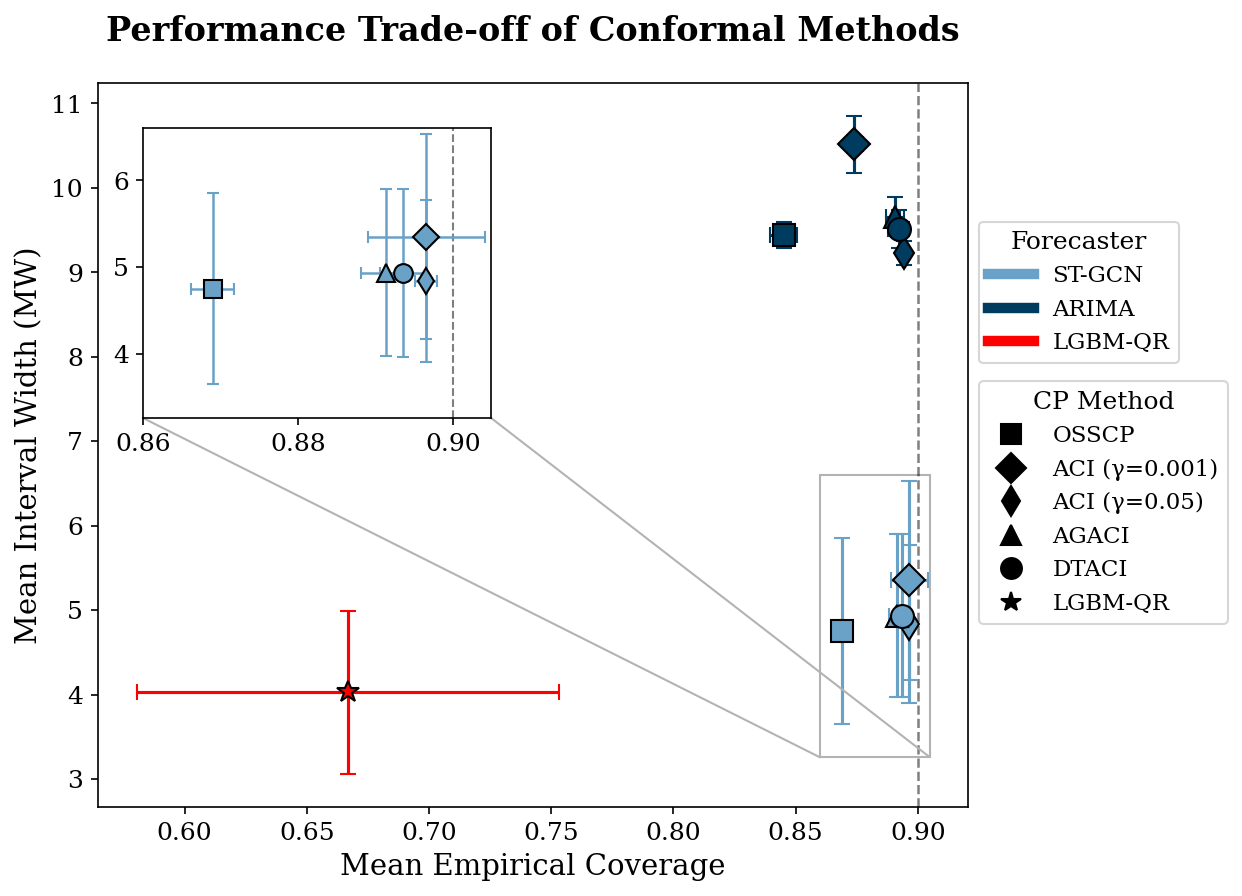

In [226]:
plot_final_tradeoff(results_df)

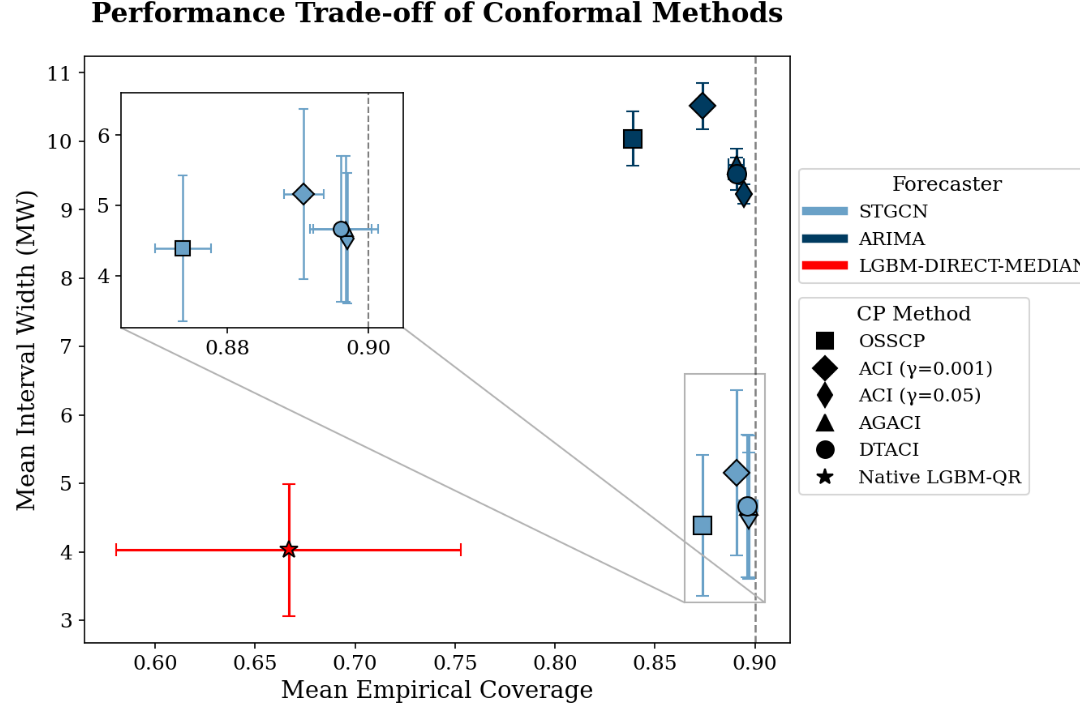

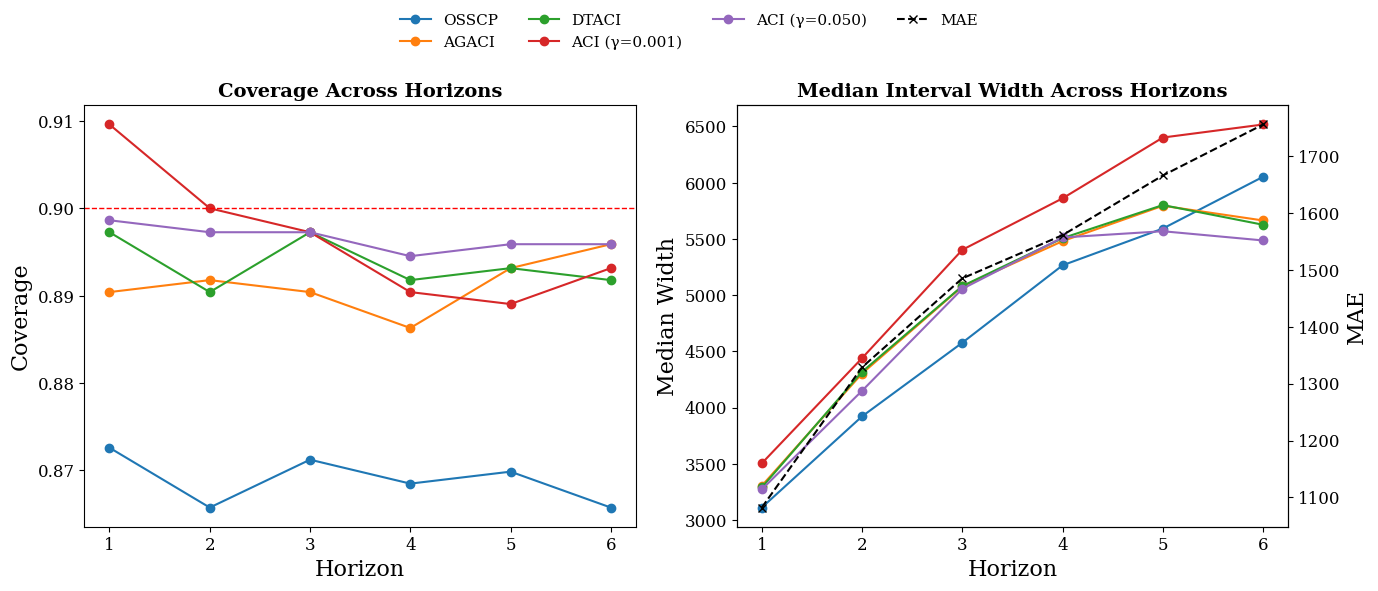

In [227]:
import re
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# === STYLE SETTINGS ===
mpl.rcParams.update({
    "font.size": 14,
    "font.family": "serif",
    "axes.labelsize": 16,
    "axes.titlesize": 18,
    "axes.spines.top": True,
    "axes.spines.right": True,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "legend.frameon": False,
    "figure.figsize": (8, 5),
    "figure.dpi": 100,
    "savefig.dpi": 300,
    "savefig.bbox": "tight",
    "savefig.format": "pdf",
})

# --- error functions ---
def compute_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def compute_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# --- interval summary from results["gcn_gru"] ONLY (back to original contract) ---
def pretty_name(method_key: str) -> str:
    s = str(method_key)
    low = s.lower()
    if low.startswith("aci_gamma"):
        # extract first number appearing after "aci_gamma"
        m = re.search(r'(\d*\.?\d+)', low)
        gamma = m.group(1) if m else s.split("gamma")[-1]
        return f"ACI (γ={gamma})"
    return s.upper()

def create_interval_table(results_subdict: dict) -> pd.DataFrame:
    """
    Expect: results_subdict = results["gcn_gru"]
    Structure: results_subdict[horizon][method] = {"coverage": ..., "median_len": ...}
    """
    rows = []
    for horizon, horizon_results in results_subdict.items():
        for method, method_results in horizon_results.items():
            rows.append({
                "Horizon": horizon,
                "Method": pretty_name(method),
                "Coverage": method_results.get("coverage", np.nan),
                "Median Width": method_results.get("median_len", np.nan),
            })
    return pd.DataFrame(rows)

# --- errors from forecasts grouped by horizon ---
def compute_errors_by_horizon(forecasts: pd.DataFrame,
                              methods: list[str],
                              actual_col: str = "actual",
                              horizon_col: str = "horizon") -> pd.DataFrame:
    """
    forecasts has columns: [horizon, actual, gcn_gru, arima, naive, ...]
    """
    out = []
    for h, g in forecasts.groupby(horizon_col):
        y = g[actual_col].values
        for m in methods:
            if m not in g.columns:
                continue
            p = g[m].values
            out.append({
                "Horizon": h,
                "Method": m.upper(),
                "MAE": compute_mae(y, p),
                "RMSE": compute_rmse(y, p),
            })
    return pd.DataFrame(out)

# --- plotting ---
def plot_performance(df: pd.DataFrame, error_metric: str = "MAE"):
    """
    - Left: Coverage per CP method
    - Right: Median Width per CP method + overlay avg error across methods at each horizon
    """
    # Only CP methods go in the left/right primary axes lines
    methods_order = ['OSSCP', 'AGACI', 'DTACI', 'ACI (γ=0.001)', 'ACI (γ=0.050)']
    colors = plt.cm.tab10.colors

    df = df.copy()
    df['Method'] = df['Method'].astype(str)
    df['Method'] = pd.Categorical(df['Method'], categories=methods_order, ordered=True)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

    # --- Coverage (CP only) ---
    ax0 = axes[0]
    for i, method in enumerate(methods_order):
        subset = df[df['Method'] == method]
        if not subset.empty and 'Coverage' in subset.columns:
            ax0.plot(subset['Horizon'], subset['Coverage'], marker='o',
                     label=method, color=colors[i % len(colors)])
    ax0.axhline(0.9, color='red', linestyle='--', linewidth=1)
    ax0.set_title("Coverage Across Horizons", fontsize=14, weight='bold')
    ax0.set_xlabel("Horizon")
    ax0.set_ylabel("Coverage")

    # --- Median Width (CP only) ---
    ax1 = axes[1]
    for i, method in enumerate(methods_order):
        subset = df[df['Method'] == method]
        if not subset.empty and 'Median Width' in subset.columns:
            ax1.plot(subset['Horizon'], subset['Median Width'], marker='o',
                     label=method, color=colors[i % len(colors)])
    ax1.set_title("Median Interval Width Across Horizons", fontsize=14, weight='bold')
    ax1.set_xlabel("Horizon")
    ax1.set_ylabel("Median Width")

    # --- Overlay average error across methods for each horizon ---
    metric = error_metric.upper()
    if metric in ["MAE", "RMSE"] and metric in df.columns:
        # average over rows that actually have the metric (i.e., forecast methods)
        err = df.groupby("Horizon", as_index=True)[metric].mean(numeric_only=True)
        ax2 = ax1.twinx()
        ax2.plot(err.index, err.values, color="black", linestyle="--", marker="x", label=metric)
        ax2.set_ylabel(metric)

        # Legends
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        fig.legend(lines1 + lines2, labels1 + labels2,
                   loc="upper center", ncol=4, frameon=False, fontsize=11)

    plt.tight_layout(rect=[0, 0, 1, 0.90])
    plt.savefig("horizon.pdf", dpi=300, bbox_inches="tight")
    plt.show()

# ======== EXAMPLE USAGE (back to your working pattern) ========
# 1) Interval results (coverage, width) from CP methods
interval_df = create_interval_table(results["stgcn"])  # <- use subdict like before

# 2) Error metrics from point forecasts dataframe
point_methods = ["stgcn", "arima", "naive"]  # adjust to your columns
error_df = compute_errors_by_horizon(forecasts, point_methods, actual_col="actual", horizon_col="horizon")

# 3) Combine (simple concat so we don't mangle either side)
df = pd.concat([interval_df, error_df], ignore_index=True, sort=False)

# 4) Plot
plot_performance(df, error_metric="MAE")

In [ ]:
import numpy as np
import pandas as pd

def compute_errors_by_horizon(forecasts: pd.DataFrame,
                              methods: list[str],
                              actual_col: str = "actual",
                              horizon_col: str = "horizon") -> pd.DataFrame:
    """
    Compute MAE and RMSE for each method, grouped by horizon.
    """
    records = []
    for h, group in forecasts.groupby(horizon_col):
        actuals = group[actual_col].values
        for method in methods:
            if method not in group:  # skip if forecast col missing
                continue
            preds = group[method].values
            mae = np.mean(np.abs(actuals - preds))
            rmse = np.sqrt(np.mean((actuals - preds) ** 2))
            records.append({
                "Horizon": h,
                "Method": method.upper(),
                "MAE": mae,
                "RMSE": rmse
            })
    return pd.DataFrame(records)


methods = ["gcn_gru"]
error_table = compute_errors_by_horizon(forecasts, methods)

print(error_table)


In [183]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_metrics_by_horizon_pub(results: dict):
    table_data = []
    for horizon, horizon_results in results.items():
        for method, method_results in horizon_results.items():
            table_data.append({
                'Horizon': horizon,
                'Method': method.upper(),
                'Coverage': method_results.get('coverage', np.nan),
                'Median Width': method_results.get('median_len', np.nan)
            })
    df = pd.DataFrame(table_data)

    # --- Styling ---
    sns.set_context("talk")  # larger fonts
    sns.set_style("whitegrid")
    palette = sns.color_palette("tab10", n_colors=df["Method"].nunique())
    markers = ["o", "s", "D", "^"]  # circle, square, diamond, triangle

    fig, axes = plt.subplots(1, 2, figsize=(14,6), sharex=True)

    # Coverage plot
    sns.lineplot(data=df, x="Horizon", y="Coverage", hue="Method",
                 style="Method", markers=markers, dashes=False,
                 palette=palette, linewidth=2.5, markersize=10, ax=axes[0])
    axes[0].axhline(0.90, color="black", linestyle="--", linewidth=1.5)
    axes[0].set_title("Coverage vs Horizon", fontsize=18, weight="bold")
    axes[0].set_ylabel("Coverage")
    axes[0].set_xlabel("Horizon")
    axes[0].set_ylim(0.87, 0.92)  # zoom in around 90%

    # Width plot
    sns.lineplot(data=df, x="Horizon", y="Median Width", hue="Method",
                 style="Method", markers=markers, dashes=False,
                 palette=palette, linewidth=2.5, markersize=10, ax=axes[1])
    axes[1].set_title("Median Interval Width vs Horizon", fontsize=18, weight="bold")
    axes[1].set_ylabel("Median Width")
    axes[1].set_xlabel("Horizon")

    # Remove duplicate legends
    axes[1].get_legend().remove()
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, title="Method", loc="upper center",
               ncol=len(labels), bbox_to_anchor=(0.5, 1.08), frameon=False)

    sns.despine()
    plt.tight_layout()
    plt.show()


In [136]:
def plot_all_prediction_intervals(
    forecasts_df: pd.DataFrame,
    results: dict,
    horizon_to_plot: int,
    start_idx: int = 100,
    end_idx: int = 300,
    figsize: tuple = (15, 7)
):
    """
    Plots actuals, forecasts from STGCN, LGBM, ARIMA, and overlays conformal prediction intervals.
    """
    # Filter the horizon slice
    horizon_df = forecasts_df[forecasts_df['horizon'] == horizon_to_plot].iloc[start_idx:end_idx]
    
    plt.style.use('seaborn-v0_8-white')
    fig, ax = plt.subplots(figsize=figsize)

    # --- Plot Actuals ---
    ax.plot(
        horizon_df.index, horizon_df['actual'], 
        color='black', label='Actual Power', lw=2.5, zorder=5
    )

    # --- Plot Forecasts ---
    forecast_models = ['stgcn', 'lgbm_direct_median', 'arima']
    model_colors = {'stgcn': 'royalblue', 'lgbm_direct_median': 'purple', 'arima': 'darkred'}

    for model in forecast_models:
        ax.plot(
            horizon_df.index, horizon_df[model].iloc[start_idx:end_idx],
            color=model_colors[model], ls='--', lw=2,
            label=f"{model.upper()} Forecast"
        )

    # --- Conformal Prediction Intervals ---
    method_colors = {
        'OSSCP': 'gray',
        'ACI_GAMMA0.001': 'darkorange',
        'ACI_GAMMA0.050': 'goldenrod',
        'AGACI': 'forestgreen',
        'DTACI': 'deepskyblue'
    }

    for model in forecast_models:
        if horizon_to_plot not in results[model]:
            continue
        for method, method_results in results[model][horizon_to_plot].items():
            lower = method_results['lower_bounds'][start_idx:end_idx]
            upper = method_results['upper_bounds'][start_idx:end_idx]

            if method.upper() == "DTACI":
                # Highlight DTACI with shading
                ax.fill_between(
                    horizon_df.index, lower, upper,
                    color=method_colors[method.upper()], alpha=0.2,
                    label=f"{model.upper()} + {method.upper()} Interval"
                )
            else:
                ax.plot(
                    horizon_df.index, lower, 
                    color=method_colors.get(method.upper(), 'gray'), ls='--', lw=1.2,
                    label=f"{model.upper()} + {method.upper()} Lower"
                )
                ax.plot(
                    horizon_df.index, upper,
                    color=method_colors.get(method.upper(), 'gray'), ls='--', lw=1.2,
                    label=f"{model.upper()} + {method.upper()} Upper"
                )

    # --- Formatting ---
    ax.set_title(f"Forecasts & Prediction Intervals (Horizon t+{horizon_to_plot})", fontsize=16)
    ax.set_xlabel("Timestamp", fontsize=12)
    ax.set_ylabel("Power Output (kW)", fontsize=12)
    ax.legend(loc='upper left', ncol=2, fontsize=9)
    plt.tight_layout()
    plt.show()

ValueError: x and y must have same first dimension, but have shapes (600,) and (200,)

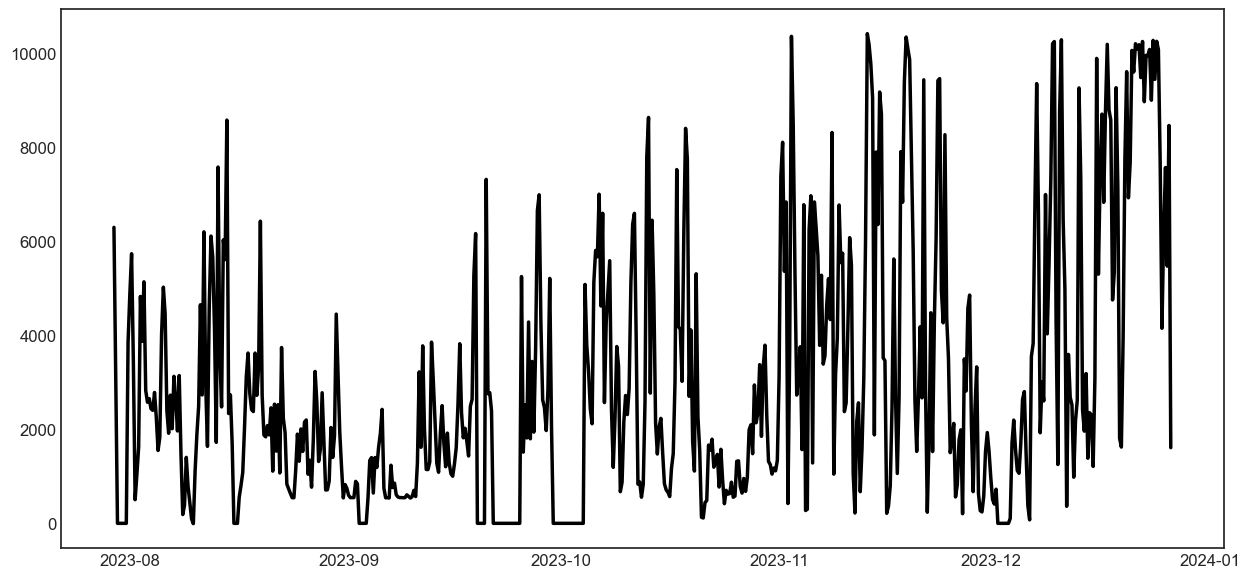

In [137]:
# --- Example Usage ---
plot_all_prediction_intervals(
    forecasts_df=forecasts.iloc[int(0.30 * len(forecasts)):],
    results=results_df,
    horizon_to_plot=6,        # e.g., show the 6-hour-ahead forecast
    start_idx=400,
    end_idx=1000
)

In [57]:
results_df

,Model,Horizon,Method,Coverage,Width
0,STGCN,1,OSSCP,0.869863,2967.894531
1,STGCN,1,ACI_GAMMA0.001,0.890411,3324.471436
2,STGCN,1,ACI_GAMMA0.050,0.897260,3008.221924
3,STGCN,1,DTACI,0.890411,2983.338379
4,STGCN,1,AGACI,0.893151,3015.976074
...,...,...,...,...,...
61,ARIMA,6,OSSCP,0.847945,9389.272578
62,ARIMA,6,ACI_GAMMA0.001,0.872603,10360.819601
63,ARIMA,6,ACI_GAMMA0.050,0.893151,9445.524761
64,ARIMA,6,DTACI,0.887671,9787.304009


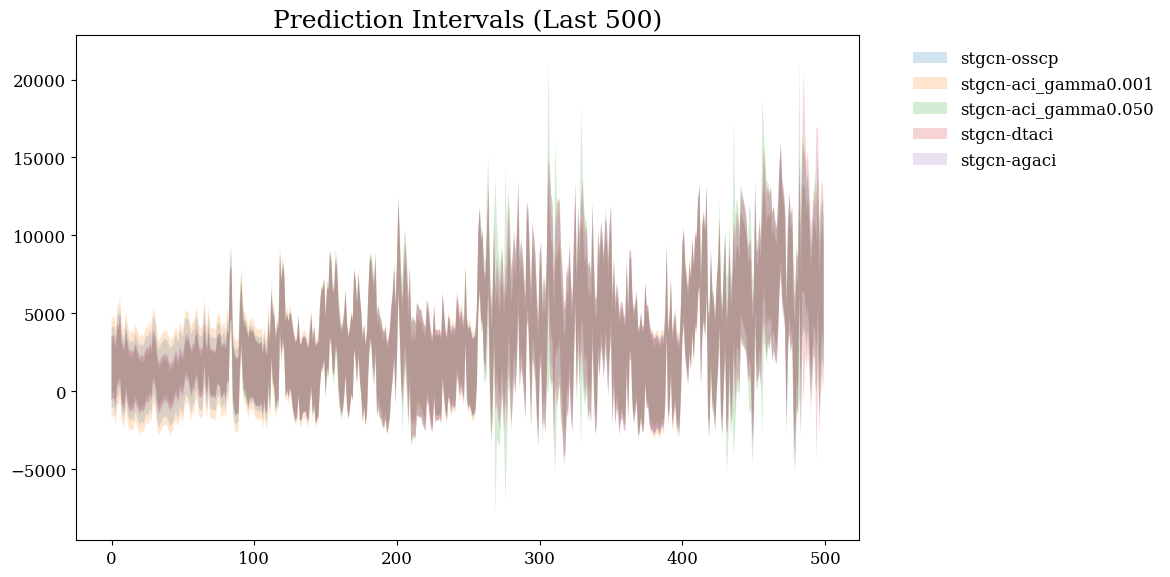

In [202]:
fig, ax = plt.subplots(figsize=(12, 6))

for model, methods in continuous_results.items():
    if model != "arima":
        for method, res in methods.items():
            if "lower_bounds" not in res:
                continue  # skip metadata
            lb = res["lower_bounds"][-500:]
            ub = res["upper_bounds"][-500:]
            ax.fill_between(
                range(len(lb)),
                lb,
                ub,
                alpha=0.2,
                label=f"{model}-{method}"
            )

ax.set_title("Prediction Intervals (Last 500)")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()